# Goal
The goal of this notebook is to find ways to meaningfully group CU customers according to their
* CU dashboard behaviours (those which have occured in the past) and 
* likelihood for subscription. 

Three ways to segment customers 
1. Cohort analysis
2. RFM segmentation 
3. Kmeans Clustering

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
df = pd.read_csv("/Users/spurushe/Downloads/chapter_1/online.csv", parse_dates=[5])
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70864 entries, 0 to 70863
Data columns (total 9 columns):
Unnamed: 0     70864 non-null int64
InvoiceNo      70864 non-null int64
StockCode      70864 non-null object
Description    70864 non-null object
Quantity       70864 non-null int64
InvoiceDate    70864 non-null datetime64[ns]
UnitPrice      70864 non-null float64
CustomerID     70864 non-null int64
Country        70864 non-null object
dtypes: datetime64[ns](1), float64(1), int64(4), object(3)
memory usage: 4.9+ MB


In [6]:
df.groupby('CustomerID')['InvoiceDate'].count()

CustomerID
12747     27
12748    967
12749     37
12820     17
12822      9
12823      1
12824      6
12826     17
12827      2
12828     12
12829      2
12830     10
12832      5
12833      5
12834      9
12836     34
12837      2
12838     22
12839     59
12840     19
12841     78
12842      8
12843     22
12844      7
12845      4
12847     14
12849     15
12851     13
12852      2
12853     12
        ... 
18236      9
18237     12
18239     17
18240      1
18241     19
18242     16
18245     40
18248     12
18249      2
18250      8
18251      3
18252     22
18257     22
18259      4
18260     30
18261      6
18262      1
18263     10
18265      9
18269      2
18270      3
18272     38
18274      2
18276      4
18277      4
18280      2
18281      2
18282      2
18283    152
18287     15
Name: InvoiceDate, Length: 3701, dtype: int64

In [7]:
def get_day(x): return dt.datetime(x.year, x.month, x.day)

def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [8]:
## We are trying to create an aquisition cohort using the day that a customer started subscribing or purchased a product

df['InvoiceDay'] = df['InvoiceDate'].apply(get_day)

cs_group = df.groupby(['CustomerID'])['InvoiceDay']

df['CohortDate'] = cs_group.transform('min') ## from the grouping done above, take the first date and use it to ascribe a cohort index
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDate
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-04-11
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-09-12
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-14,2011-07-14
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-23,2011-11-23
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-25,2011-02-25


In [9]:
## Calculating a time offset 

# 1. 
# get ints from invoiceday and the cohortday
invoice_year, invoice_month, invoice_day = get_date_int(df, 'InvoiceDay')
cohort_year, cohort_month, cohort_day = get_date_int(df, 'CohortDate')

In [10]:
# 2.
# Find the difference in years between the moment of the invoice and the moment the cohort was created.

# Calculate difference in years
years_diff = invoice_year - cohort_year 

months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# 3. 
# Extract the difference in days from all previous values
df['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
df.head()

,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDate,CohortIndex
0,416792,572558,22745,POPPY'S PLAYHOUSE BEDROOM,6,2011-10-25 08:26:00,2.10,14286,United Kingdom,2011-10-25,2011-04-11,195
1,482904,577485,23196,VINTAGE LEAF MAGNETIC NOTEPAD,1,2011-11-20 11:56:00,1.45,16360,United Kingdom,2011-11-20,2011-09-12,69
2,263743,560034,23299,FOOD COVER WITH BEADS SET 2,6,2011-07-14 13:35:00,3.75,13933,United Kingdom,2011-07-14,2011-07-14,1
3,495549,578307,72349B,SET/6 PURPLE BUTTERFLY T-LIGHTS,1,2011-11-23 15:53:00,2.10,17290,United Kingdom,2011-11-23,2011-11-23,1
4,204384,554656,21756,BATH BUILDING BLOCK WORD,3,2011-05-25 13:36:00,5.95,17663,United Kingdom,2011-05-25,2011-02-25,91


We have now given each transaction a Cohort Index (meaning which cohort it belongs to) which is the difference between the day the customer first subscribed/purchased and the transaction date per row.

## 2. Segmentation using RFM metrics
Metrics used 
* Recency -- time unit since last transaction (the lower the better) 
* Frequency -- number of transactions in the last (unit of time) (the higher the better)
* Monetary Value -- total spend by the customer in the (unit of time) (the higher the better)

Unit of time is chosen according to the (1) business model and the (2) product and customer lifecycle.

Followed by Segmentation of RFM values which can be done by 
1. Percentiles or quantiles 
2. Pareto split i.e. 80/20 rule 
3. Based on predefined thresholds decided through business knowledge

#### Some data preprocessing

In [11]:
print('Min {}; Max {};'.format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min 2010-12-01 08:26:00; Max 2011-12-09 12:49:00;


**(A) Data should be very recent i.e. either today or yesterday. Else we need to create a hypothetical 'today' mimicking a recent snapshot of the data.  
We will use this hypothetical today to calculate the recency.**

In [12]:
# Creating the hypothetical today. i.e. snapshot_date

snapshot_date = df.InvoiceDate.max() + dt.timedelta(days=1)
print(snapshot_date)

2011-12-10 12:49:00


**(B)TotalSum for a given transaction i.e. UnitPrice * number of items.**  

In [13]:
df['TotalSum'] = df['UnitPrice'] * df['Quantity']

RFM calculation

In [14]:
# RFM calculation
rfm_df = df.groupby(['CustomerID'])\
            .agg({
                'InvoiceDate': lambda x: (snapshot_date - x.max()).days, # today - most recent transaction RECENCY
                'InvoiceNo': 'count', # Number of all transactions FREQUENCY
                'TotalSum': 'sum'
            })

#Renaming columns
rfm_df.rename(columns = {
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalSum':'MonetaryValue'
}, inplace = True)

rfm_df.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12747,2,27,992.82
12748,1,967,7522.06
12749,4,37,813.45
12820,3,17,268.02
12822,71,9,146.15


#### RFM segmentation using Percentiles

In [15]:
r_labels = range(4, 0, -1) ## remember the lesser the recency, the higher its rank
f_labels = range(1, 5 , 1) ## the other two are reversed with respect to values and their ranks
m_labels = range(1, 5 , 1)

r_quartiles = pd.qcut(rfm_df['Recency'], q = 4, labels = r_labels) # creates a Series
f_quartiles = pd.qcut(rfm_df['Frequency'], q = 4, labels = f_labels)
m_quartiles = pd.qcut(rfm_df['MonetaryValue'], q = 4, labels = m_labels)

rfm_df = rfm_df.assign(R = r_quartiles.values)
rfm_df = rfm_df.assign(F = f_quartiles.values)
rfm_df = rfm_df.assign(M = m_quartiles.values)

Calculating the RFM segment and RFM score that each transaction (Customer ID) gets.

In [16]:
def concat_score(x): return(str(x['R']) + str(x['F']) + str(x['M']))

rfm_df['RFM_Segment'] = rfm_df.apply(concat_score, axis=1)
rfm_df['RFM_Score']= rfm_df[['R', 'F', 'M']].sum(axis = 1)

rfm_df.head(5)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12747,2,27,992.82,4,4,4,444,12.0
12748,1,967,7522.06,4,4,4,444,12.0
12749,4,37,813.45,4,4,4,444,12.0
12820,3,17,268.02,4,3,3,433,10.0
12822,71,9,146.15,2,2,3,223,7.0


In [17]:
#Distribution of counts through out segments (most populous segments)
rfm_df.groupby('RFM_Segment').size().sort_values(ascending = False)[ :10]

RFM_Segment
444    382
111    346
211    168
344    162
233    132
222    130
311    120
433    119
333    118
122    116
dtype: int64

TODO : Create groups using a custome defined threshold for RFM_Score i.e. Low, medium. high 

## 3. Segmentation using KMeans Clustering

1. Preprocessing
2. Determining the right number of k clusters -- using visual elbow criterion 
3. Kmeans using this k
4. Profile and analysis of clusters 

1. Preprocessing the data 

<Figure size 432x288 with 0 Axes>

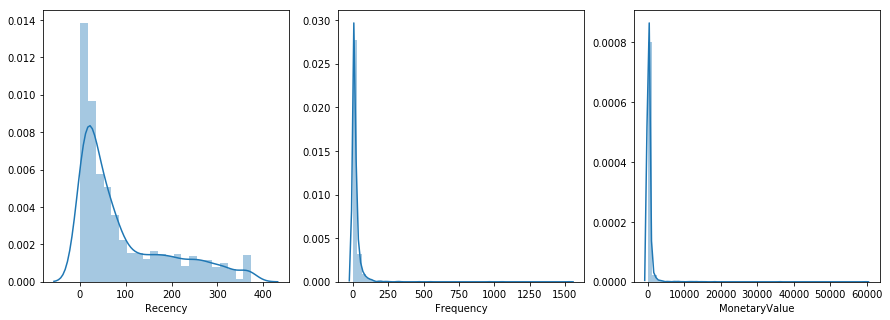

In [33]:
# checking for skewness of the data 

#### BEFORE

fig = plt.figure()
plt.figure(figsize=(15,5))

# visual 
plt.subplot(1,3,1); sns.distplot(rfm_df['Recency'])
plt.subplot(1,3,2); sns.distplot(rfm_df['Frequency'])
plt.subplot(1,3,3); sns.distplot(rfm_df['MonetaryValue'])

plt.show()

# TODO what do we do for big data ??

All three of them have a skew to the right. We can fix this using a log transformation. Log transformations work only on positive values so it works because our customer data is 'activity data' which is always positive. 

<Figure size 432x288 with 0 Axes>

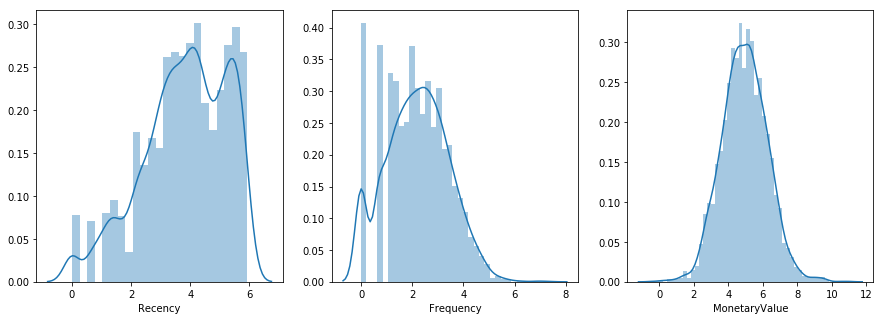

In [44]:
#### AFTER

rfm_df_log = rfm_df[['Recency', 'Frequency', 'MonetaryValue']].apply(np.log)

fig = plt.figure()
plt.figure(figsize=(15,5))

# visual 
plt.subplot(1,3,1); sns.distplot(rfm_df_log['Recency'])
plt.subplot(1,3,2); sns.distplot(rfm_df_log['Frequency'])
plt.subplot(1,3,3); sns.distplot(rfm_df_log['MonetaryValue'])

plt.show()


In [52]:
# Checking for centrality of the data 

# Kmeans needs all attributes to have the same mean and same variance so that each attribute contributes 
# equal importance to the clustering

#Before centering and scaling
rfm_df.describe()

,Recency,Frequency,MonetaryValue,RFM_Score
count,3701.000000,3701.000000,3701.000000,3701.000000
mean,94.298568,19.147257,380.535069,7.443394
std,99.974969,44.831615,1474.285937,2.825434
min,1.000000,1.000000,0.650000,3.000000
25%,19.000000,4.000000,59.400000,5.000000
50%,52.000000,9.000000,140.300000,7.000000
75%,151.000000,21.000000,337.800000,10.000000
max,374.000000,1532.000000,59596.070000,12.000000


In [56]:
# Lets use a Standard scaler to move all the means closer to one another. 
scalar = StandardScaler()

tr_df = scalar.fit(rfm_df_log).transform(rfm_df_log)

rfm_transformed = pd.DataFrame(tr_df, index= rfm_df.index, columns = rfm_df_log.columns)

#After centering and scaling 
rfm_transformed.describe().round(2).head()

,Recency,Frequency,MonetaryValue
count,3701.00,3701.00,3701.00
mean,0.00,0.00,0.00
std,1.00,1.00,1.00
min,-2.68,-1.79,-4.09
25%,-0.61,-0.66,-0.66


2. Determining the right number of k clusters -- using visual elbow criterion  
TODO explain this section a little bit 

In [57]:
sse_dict = {}
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_transformed)
    sse_dict[k] = kmeans.inertia_

Lets visualize this using a pointplot and look for the cluster number where the decrease is steep. The idea is to use this as an estimate and experiment with some k values above and below this. 

Text(0.5, 1.0, 'Choosing the right k value using the elbow criterion method ')

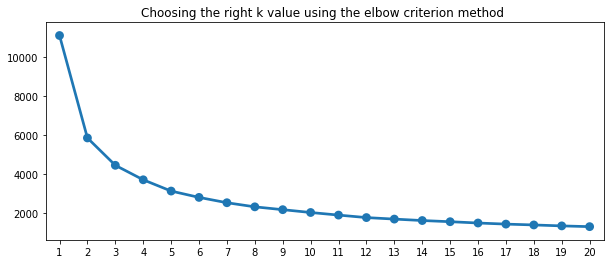

In [59]:
plt.figure(figsize=(10, 4))

sns.pointplot(x=list(sse_dict.keys()), y=list(sse_dict.values()))
plt.title('Choosing the right k value using the elbow criterion method ')

So we should experiment with 2-5 clusters as the value of k. 